In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, pickle, cv2, glob, gc
import seaborn as sn
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow import keras
from tensorflow.keras import layers, Sequential, applications, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from skimage import color
from skimage.feature import hog
import joblib

import warnings
warnings.filterwarnings('ignore')

## 1. Učitavanje podataka

In [2]:
DIR_TRAIN = './sign_data/Dataset/train'
DIR_TEST = './sign_data/Dataset/test'
DIR_VAL = './sign_data/Dataset/val'
DATA_TRAIN_CSV = './sign_data/new_train_data.csv'
DATA_TRAIN_ALL_CSV = './sign_data/new_train_all_data.csv'
DATA_TEST_CSV = './sign_data/new_test_data.csv'
DATA_VAL_CSV = './sign_data/new_val_data.csv'

SIZE = 224

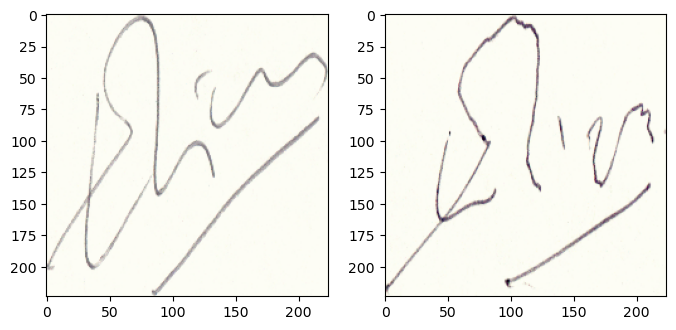

In [3]:
# examples of true and forged signatures

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/train/001/001_01.PNG'), (SIZE,SIZE)), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/train/001_forg/0119001_01.png'), (SIZE,SIZE)), cmap='gray')
plt.savefig('plot_example_trueforged.pdf')
plt.show()

In [3]:
# LOAD PICKLED FILES

with open('./train_data_names.pkl', 'rb') as file:
    filenames_train = pickle.load(file)
with open('./val_data_names.pkl', 'rb') as file:
    filenames_val = pickle.load(file)
with open('./test_data_names.pkl', 'rb') as file:
    filenames_test = pickle.load(file)
with open('./train_all_data_names.pkl', 'rb') as file:
    filenames_train_all = pickle.load(file)
    
with open('./train_imgs.pkl', 'rb') as file:
    imgs_train = pickle.load(file)
with open('./val_imgs.pkl', 'rb') as file:
    imgs_val = pickle.load(file)
with open('./test_imgs.pkl', 'rb') as file:
    imgs_test = pickle.load(file)
with open('./train_all_imgs.pkl', 'rb') as file:
    imgs_train_all = pickle.load(file)
with open('./train_labels.pkl', 'rb') as file:
    labels_train = pickle.load(file)
with open('./val_labels.pkl', 'rb') as file:
    labels_val = pickle.load(file)
with open('./test_labels.pkl', 'rb') as file:
    labels_test = pickle.load(file)

./sign_data/Dataset/train/009_forg\0117009_02.png


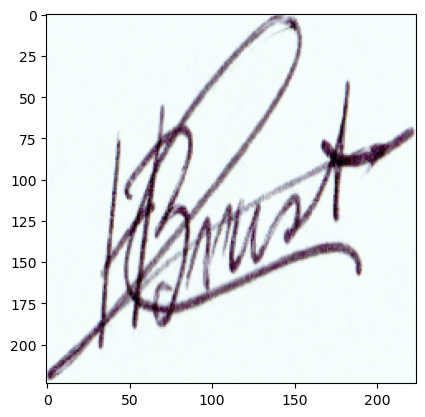

In [4]:
print(filenames_train[200])
plt.imshow(imgs_train[200])
plt.show()

In [5]:
print(len(imgs_train))
print(len(imgs_val))
print(len(imgs_train_all))
print(len(imgs_test))

1057
248
1305
344


## 2. VGG16 značajke

In [7]:
INPUT_SIZE = (224,224,3)
OUTPUT_SIZE = 2
EPOCHS = 14
BATCH_SIZE = 64

VGG16
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)           

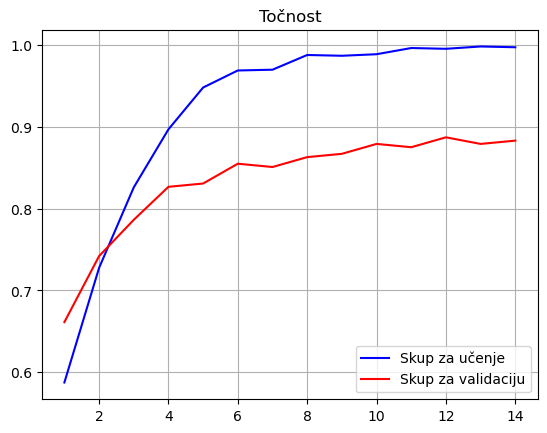

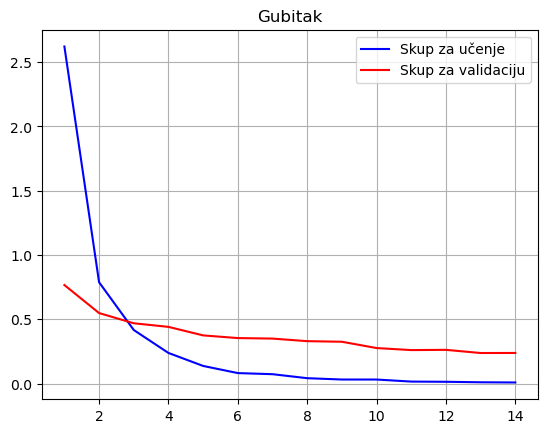

In [8]:
# VGG16 finetuning (ADAM, 256 features) - last four layers unfrozen

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SIZE)

# freeze layers
for layer in base_model.layers[:15]:
    layer.trainable = False
# check
print('VGG16')
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
print()

model_vgg2 = Sequential()
model_vgg2.add(base_model)
model_vgg2.add(Flatten())
model_vgg2.add(Dense(256, activation='relu'))
model_vgg2.add(Dropout(0.5))
model_vgg2.add(Dense(OUTPUT_SIZE, activation='softmax'))

checkpoint_path = "training_vgg16adam_new/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,verbose=1,save_best_only=True)

model_vgg2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['accuracy'])
model_vgg2.summary()

X_tr, y_tr = shuffle(preprocess_vgg16(np.copy(imgs_train)*255.), labels_train, random_state=5)
X_v, y_v = shuffle(preprocess_vgg16(np.copy(imgs_val)*255.), labels_val, random_state=5)
progess = model_vgg2.fit(X_tr, y_tr, validation_data=(X_v, y_v), 
                         batch_size=BATCH_SIZE,epochs=EPOCHS, callbacks=[cp_callback])
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = [i for i in range(1, len(acc)+1)]

plt.plot(epochs, acc, 'b', label='Skup za učenje')
plt.plot(epochs, val_acc, 'r', label='Skup za validaciju')
plt.title('Točnost')
plt.legend()
plt.grid()
plt.savefig('plot_VGG16_Adam_acc_new.pdf')
plt.show()

plt.plot(epochs, loss, 'b', label='Skup za učenje')
plt.plot(epochs, val_loss, 'r', label='Skup za validaciju')
plt.title('Gubitak')
plt.legend()
plt.grid()
plt.savefig('plot_VGG16_Adam_loss_new.pdf')
plt.show()

In [9]:
# extract features from fine-tuned model

extractor_model_vgg2 = Model(inputs=model_vgg2.input, outputs=model_vgg2.layers[-3].output)

extracted_fts_train = extractor_model_vgg2.predict(preprocess_vgg16(np.copy(imgs_train)*255.))
np.save('./VGG16_Adam_train_new', extracted_fts_train)
extracted_fts_val = extractor_model_vgg2.predict(preprocess_vgg16(np.copy(imgs_val)*255.))
np.save('./VGG16_Adam_val_new', extracted_fts_val)
extracted_fts_test = extractor_model_vgg2.predict(preprocess_vgg16(np.copy(imgs_test)*255.))
np.save('./VGG16_Adam_test_new', extracted_fts_test)
extracted_fts_train_all = extractor_model_vgg2.predict(preprocess_vgg16(np.copy(imgs_train_all)*255.))
np.save('./VGG16_Adam_train_all_new', extracted_fts_train_all)

extractor_model_vgg2.save('extractor_model_vgg2.h5')

In [10]:
print(extracted_fts_train.shape)

(1057, 256)


In [ ]:
# load features

with open('./VGG16_Adam_train_new.pkl', 'rb') as file:
    extracted_fts_train = pickle.load(file)
with open('./VGG16_Adam_val_new.pkl', 'rb') as file:
    extracted_fts_val = pickle.load(file)
with open('./VGG16_Adam_test_new.pkl', 'rb') as file:
    extracted_fts_test = pickle.load(file)

In [15]:
# load train/val/test set

data_train = pd.read_csv(DATA_TRAIN_CSV)
data_val = pd.read_csv(DATA_VAL_CSV)
data_test = pd.read_csv(DATA_TEST_CSV)
X_train = data_train[['img1','img2']]
y_train = data_train[['target']]
X_val = data_val[['img1','img2']]
y_val = data_val[['target']]
X_test = data_test[['img1','img2']]
y_test = data_test[['target']]

filenames_train_t = [i.split('/')[-1].replace('\\','/') for i in filenames_train]
filenames_val_t = [i.split('/')[-1].replace('\\','/') for i in filenames_val]
filenames_test_t = [i.split('/')[-1].replace('\\','/') for i in filenames_test]

# map images to features

a,b,c,d = filenames_train_t, filenames_val_t, extracted_fts_train, extracted_fts_val
e,f = filenames_test_t, extracted_fts_test

def name2feat_train(name):
    index = a.index(name)
    return c[index]

def name2feat_val(name):
    index = b.index(name)
    return d[index]

def name2feat_test(name):
    index = e.index(name)
    return f[index]
        
X_train['img1'] = X_train['img1'].apply(name2feat_train)
X_train['img2'] = X_train['img2'].apply(name2feat_train)
X_val['img1'] = X_val['img1'].apply(name2feat_val)
X_val['img2'] = X_val['img2'].apply(name2feat_val)
X_test['img1'] = X_test['img1'].apply(name2feat_test)
X_test['img2'] = X_test['img2'].apply(name2feat_test)

new_data_train = []
for index,row in X_train.iterrows():
    new_list = list(row[0])
    new_list.extend(row[1])
    new_data_train.append(new_list)

new_data_val = []
for index,row in X_val.iterrows():
    new_list = list(row[0])
    new_list.extend(row[1])
    new_data_val.append(new_list)
    
new_data_test = []
for index,row in X_test.iterrows():
    new_list = list(row[0])
    new_list.extend(row[1])
    new_data_test.append(new_list)

new_data_train_i = [i for i in range(len(new_data_train))]
new_data_train, new_data_train_i, y_train = shuffle(new_data_train, new_data_train_i, y_train, random_state=5)
with open('./vgg16_new_data_train_i.pkl', 'wb') as file:
    pickle.dump(new_data_train_i, file)
del new_data_train_i

new_data_val_i = [i for i in range(len(new_data_val))]
new_data_val, new_data_val_i, y_val = shuffle(new_data_val, new_data_val_i, y_val, random_state=5)
with open('./vgg16_new_data_val_i.pkl', 'wb') as file:
    pickle.dump(new_data_val_i, file)
del new_data_val_i

new_data_test_i = [i for i in range(len(new_data_test))]
new_data_test, new_data_test_i, y_test = shuffle(new_data_test, new_data_test_i, y_test, random_state=5)
with open('./vgg16_new_data_test_i.pkl', 'wb') as file:
    pickle.dump(new_data_test_i, file)
del new_data_test_i

# save

with open('./vgg16_new_data_train.pkl', 'wb') as file:
    pickle.dump(new_data_train, file)
with open('./vgg16_new_data_val.pkl', 'wb') as file:
    pickle.dump(new_data_val, file)
with open('./vgg16_new_data_test.pkl', 'wb') as file:
    pickle.dump(new_data_test, file)
with open('./vgg16_y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)
with open('./vgg16_y_val.pkl', 'wb') as file:
    pickle.dump(y_val, file)
with open('./vgg16_y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [48]:
# load features

with open('./vgg16_new_data_train.pkl', 'rb') as file:
    new_data_train = pickle.load(file)
with open('./vgg16_new_data_val.pkl', 'rb') as file:
    new_data_val = pickle.load(file)
with open('./vgg16_new_data_test.pkl', 'rb') as file:
    new_data_test = pickle.load(file)
with open('./vgg16_y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
with open('./vgg16_y_val.pkl', 'rb') as file:
    y_val = pickle.load(file)
with open('./vgg16_y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

### RandomForestClassifier

fitting...
predicting...
Accuracy 0.9397759103641457
P,R,F1: (0.9391369337752649, 0.9399088541666667, 0.9394850553099143, None)


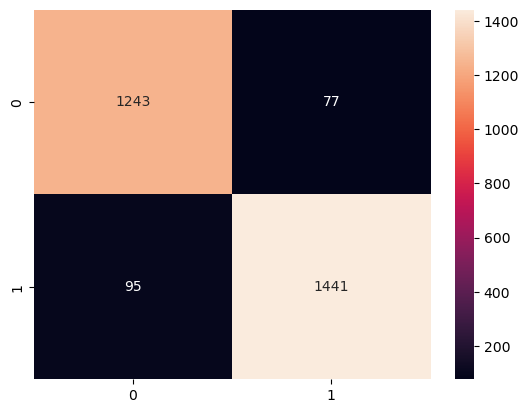

['vgg16_rf_model1.sav']

In [55]:
# classification - RandomForestClassifier
# train on train data, validate on validation data

clf = RandomForestClassifier(random_state=5)
print('fitting...')
clf.fit(new_data_train, y_train)
print('predicting...')
y_pred = clf.predict(new_data_val)

print("Accuracy", accuracy_score(y_val, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_val, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_val,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_rf_val.pdf')
plt.show()

joblib.dump(clf, 'vgg16_rf_model1.sav')  # loaded_model = joblib.load(filename) 

fitting...
Accuracy 0.9202127659574468
P,R,F1: (0.9211959479015919, 0.9201404286770141, 0.9201562898156799, None)


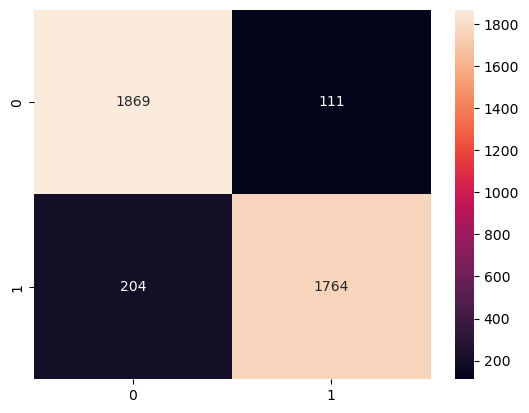

In [57]:
# train on train+val, test on test data
clf = RandomForestClassifier(random_state=5)
print('fitting...')
clf.fit(np.vstack((new_data_train,new_data_val)), np.vstack((y_train,y_val)))
joblib.dump(clf, 'vgg16_rf_model2.sav')
y_pred = clf.predict(new_data_test)

print("Accuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_rf_test2.pdf')
plt.show()

In [65]:
# test examples misclassified by rf

misclass= []
for row_index, (inpt, pred, label) in enumerate(zip(new_data_test, y_pred, y_test.to_numpy().reshape(-1))):
    if pred != label:
        misclass.append((row_index, pred, label))

with open('./vgg16_new_data_test_i.pkl', 'rb') as file:
    new_data_test_i = pickle.load(file)
data_test = pd.read_csv(DATA_TEST_CSV)
X_test = data_test[['img1','img2']]
    
for row_index, pred, label in misclass[33:38]:
    index_og = new_data_test_i[row_index]
    print('pred:',pred,'true:',label,end=' ')
    files = X_test.iloc[index_og]
    print(files['img1'],files['img2'])

pred: 1 true: 0 068/08_068.png 068/11_068.png
pred: 0 true: 1 067/08_067.png 067_forg/02_0205067.PNG
pred: 0 true: 1 056/06_056.png 056_forg/01_0105056.PNG
pred: 1 true: 0 058/05_058.png 058/11_058.png
pred: 0 true: 1 056/09_056.png 056_forg/01_0105056.PNG


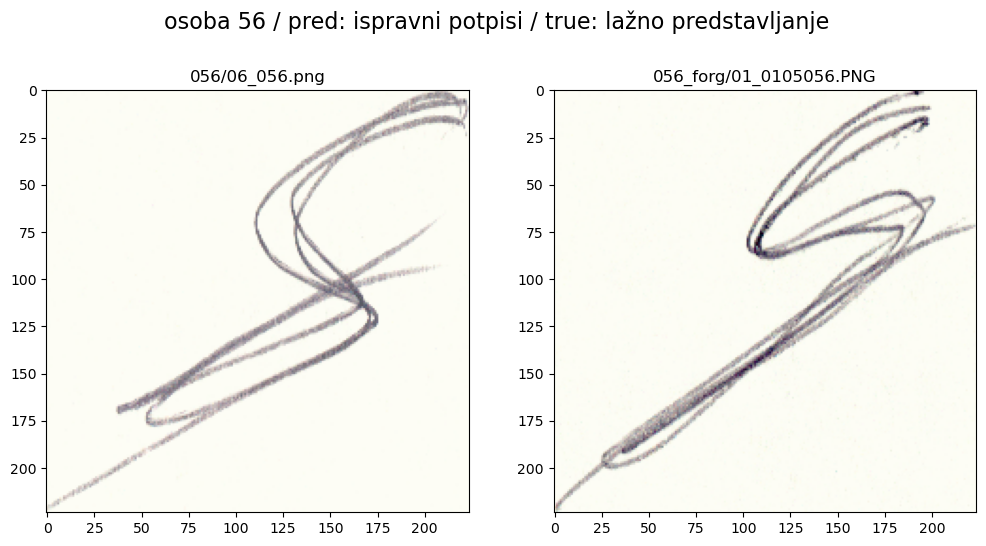

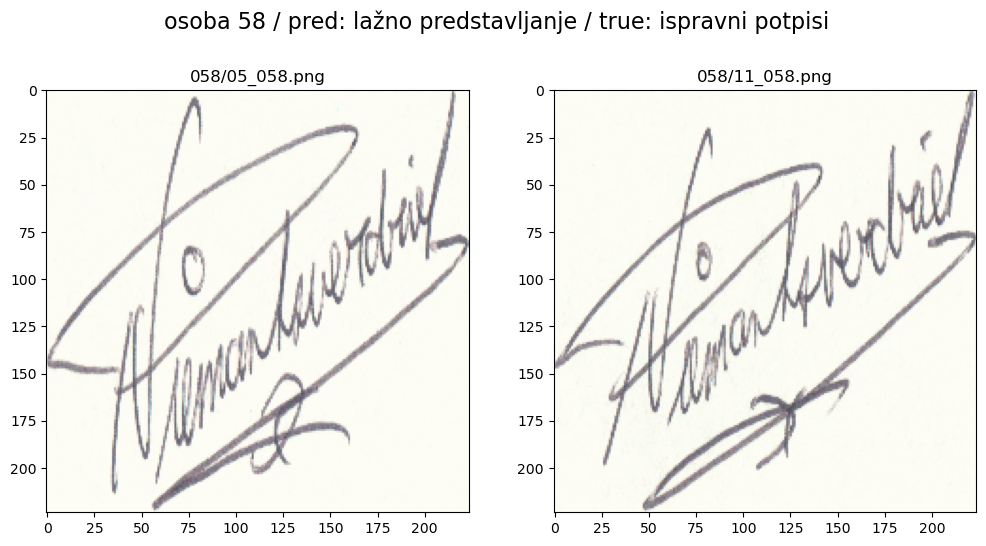

In [67]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('osoba 56 / pred: ispravni potpisi / true: lažno predstavljanje', fontsize=16)
plt.subplot(1,2,1, title='056/06_056.png')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/056/06_056.png'), (SIZE,SIZE)), cmap='gray')
plt.subplot(1,2,2, title='056_forg/01_0105056.PNG')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/056_forg/01_0105056.PNG'), (SIZE,SIZE)), cmap='gray')
plt.savefig('plot_vgg16_rf_misclassification1.pdf')
plt.show()

fig = plt.figure(figsize=(12,6))
fig.suptitle('osoba 58 / pred: lažno predstavljanje / true: ispravni potpisi', fontsize=16)
plt.subplot(1,2,1, title='058/05_058.png')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/058/05_058.png'), (SIZE,SIZE)), cmap='gray')
plt.subplot(1,2,2,title='058/11_058.png')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/058/11_058.png'), (SIZE,SIZE)), cmap='gray')
plt.savefig('plot_vgg16_rf_misclassification2.pdf')
plt.show()

### Linearni SVM

fitting...
predicting...
Accuracy 0.9226190476190477
P,R,F1: (0.927839255980795, 0.918844696969697, 0.9214999648651725, None)


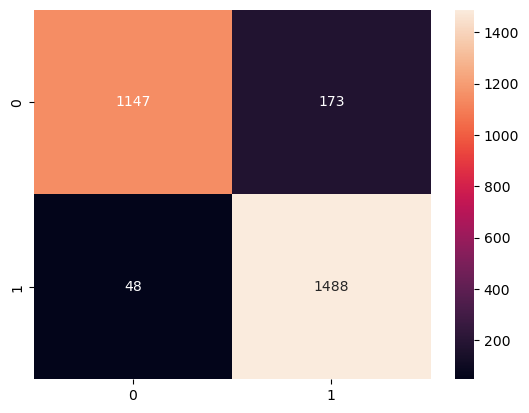

['vgg16_linsvm_model1.sav']

In [51]:
# classification - Linear SVM
# train on train data, validate on validation data

clf = svm.SVC(kernel='linear',random_state=5)
print('fitting...')
clf.fit(new_data_train, y_train)
print('predicting...')
y_pred = clf.predict(new_data_val)

print("Accuracy", accuracy_score(y_val, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_val, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_val,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_linsvm_val.pdf')
plt.show()

joblib.dump(clf, 'vgg16_linsvm_model1.sav')  # loaded_model = joblib.load(filename) 

fitting...
Accuracy 0.898176291793313
P,R,F1: (0.8998626539343151, 0.8980783444198078, 0.8980517303178512, None)


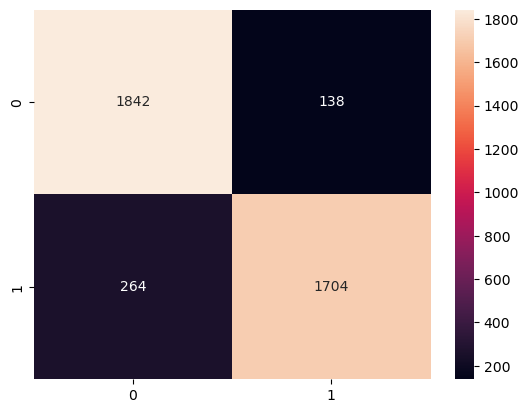

In [52]:
# train on train+val, test on test data
clf = svm.SVC(kernel='linear',random_state=5)
print('fitting...')
clf.fit(np.vstack((new_data_train,new_data_val)), np.vstack((y_train,y_val)))
joblib.dump(clf, 'vgg16_linsvm_model2.sav')
y_pred = clf.predict(new_data_test)

print("Accuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_linsvm_test2.pdf')
plt.show()

### RBF SVM

fitting...
predicting...
Accuracy 0.9184173669467787
P,R,F1: (0.922823336039267, 0.9148851799242423, 0.917306632451761, None)


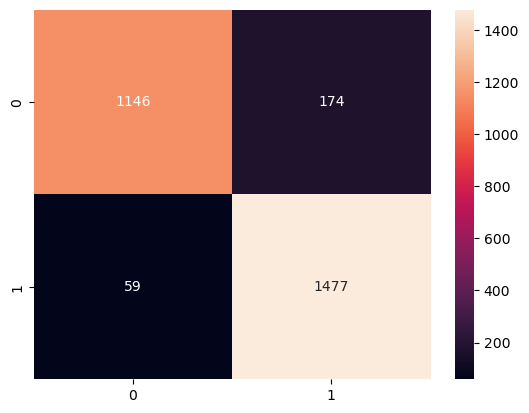

['vgg16_rbfsvm_model1.sav']

In [53]:
# classification - rbf SVM
# train on train data, validate on validation data

clf = svm.SVC(random_state=5)
print('fitting...')
clf.fit(new_data_train, y_train)
print('predicting...')
y_pred = clf.predict(new_data_val)

print("Accuracy", accuracy_score(y_val, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_val, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_val,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_rbfsvm_val.pdf')
plt.show()

joblib.dump(clf, 'vgg16_rbfsvm_model1.sav')  # loaded_model = joblib.load(filename) 

fitting...
Accuracy 0.9191995947315096
P,R,F1: (0.919747775086988, 0.9191457255481645, 0.9191655686343829, None)


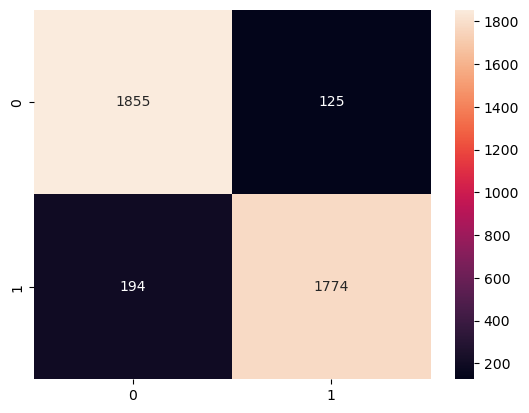

In [54]:
# train on train+val, test on test data
clf = svm.SVC(random_state=5)
print('fitting...')
clf.fit(np.vstack((new_data_train,new_data_val)), np.vstack((y_train,y_val)))
joblib.dump(clf, 'vgg16_rbfsvm_model2.sav')
y_pred = clf.predict(new_data_test)

print("Accuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_rbfsvm_test2.pdf')
plt.show()

### Logistička regresija

fitting...
predicting...
Accuracy 0.9054621848739496
P,R,F1: (0.910007833723677, 0.901669034090909, 0.9041192704947669, None)


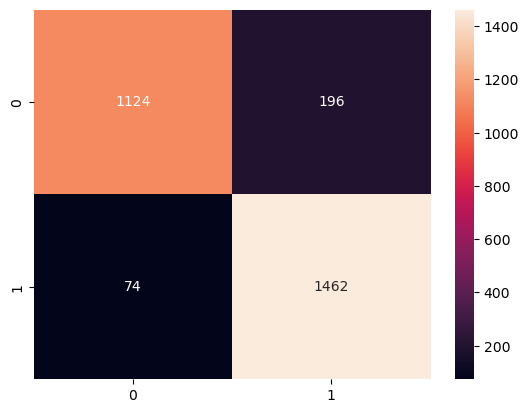

['vgg16_logreg_model1.sav']

In [41]:
# classification - logreg
# train on train data, validate on validation data

clf = LogisticRegression(random_state=5,solver='liblinear')
print('fitting...')
clf.fit(new_data_train, y_train)
print('predicting...')
y_pred = clf.predict(new_data_val)

print("Accuracy", accuracy_score(y_val, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_val, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_val,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_logreg_val.pdf')
plt.show()

joblib.dump(clf, 'vgg16_logreg_model1.sav')  # loaded_model = joblib.load(filename) 

fitting...
Accuracy 0.9083080040526849
P,R,F1: (0.9112270203858754, 0.9081808943089431, 0.9081254184953607, None)


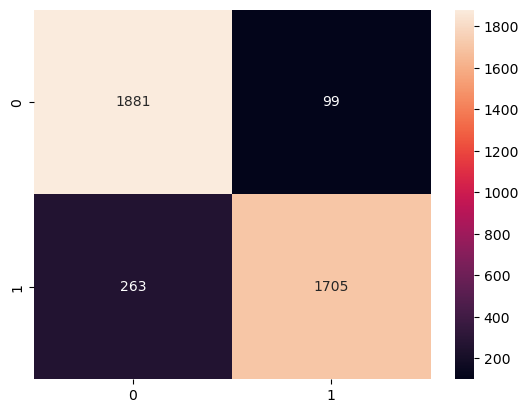

In [42]:
# train on train+val, test on test data
clf = LogisticRegression(random_state=5,solver='liblinear')
print('fitting...')
clf.fit(np.vstack((new_data_train,new_data_val)), np.vstack((y_train,y_val)))
joblib.dump(clf, 'vgg16_logreg_model2.sav')
y_pred = clf.predict(new_data_test)

print("Accuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_vgg16_heatmap_logreg_test2.pdf')
plt.show()

## 3. Histogrami orijentiranih gradijenata kao značajke

In [ ]:
# calculate HOG features
# convert to grayscale before calculating 

imgs_train_gray = [color.rgb2gray(i) for i in imgs_train]
ppc = 16
hog_images_train = []
hog_features_train = []
for image in imgs_train_gray:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images_train.append(hog_image)
    hog_features_train.append(fd)

imgs_val_gray = [color.rgb2gray(i) for i in imgs_val]
ppc = 16
hog_images_val = []
hog_features_val = []
for image in imgs_val_gray:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images_val.append(hog_image)
    hog_features_val.append(fd)
    
imgs_test_gray = [color.rgb2gray(i) for i in imgs_test]
ppc = 16
hog_images_test = []
hog_features_test = []
for image in imgs_test_gray:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images_test.append(hog_image)
    hog_features_test.append(fd)

with open('./hog_features_train.pkl', 'wb') as file:
    pickle.dump(hog_features_train, file)
with open('./hog_images_train.pkl', 'wb') as file:
    pickle.dump(hog_images_train, file)
with open('./hog_features_val.pkl', 'wb') as file:
    pickle.dump(hog_features_val, file)
with open('./hog_images_val.pkl', 'wb') as file:
    pickle.dump(hog_images_val, file)
with open('./hog_features_test.pkl', 'wb') as file:
    pickle.dump(hog_features_test, file)
with open('./hog_images_test.pkl', 'wb') as file:
    pickle.dump(hog_images_test, file)

In [8]:
# load pickled HOG features & images

with open('./hog_features_train.pkl', 'rb') as file:
    hog_features_train = pickle.load(file)
with open('./hog_images_train.pkl', 'rb') as file:
    hog_images_train = pickle.load(file)
with open('./hog_features_val.pkl', 'rb') as file:
    hog_features_val = pickle.load(file)
#with open('./hog_images_val.pkl', 'rb') as file:
#    hog_images_val = pickle.load(file)
with open('./hog_features_test.pkl', 'rb') as file:
    hog_features_test = pickle.load(file)
#with open('./hog_images_test.pkl', 'rb') as file:
#    hog_images_test = pickle.load(file)

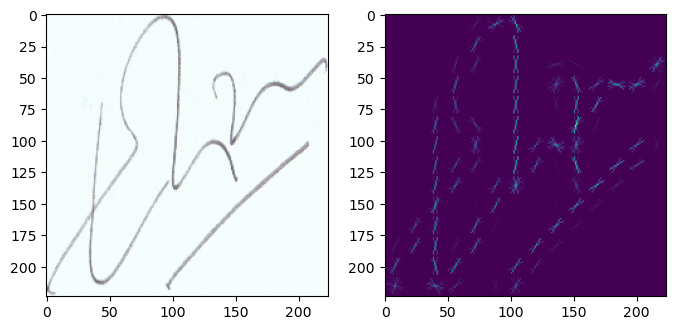

In [9]:
# show example

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(imgs_train[1])
plt.subplot(1,2,2)
plt.imshow(hog_images_train[1])
plt.savefig('plot_hog_example.pdf')
plt.show()

In [5]:
# load train/val/test set

data_train = pd.read_csv(DATA_TRAIN_CSV)
data_val = pd.read_csv(DATA_VAL_CSV)
data_test = pd.read_csv(DATA_TEST_CSV)
X_train = data_train[['img1','img2']]
y_train = data_train[['target']]
X_val = data_val[['img1','img2']]
y_val = data_val[['target']]
X_test = data_test[['img1','img2']]
y_test = data_test[['target']]

filenames_train_t = [i.split('/')[-1].replace('\\','/') for i in filenames_train]
filenames_val_t = [i.split('/')[-1].replace('\\','/') for i in filenames_val]
filenames_test_t = [i.split('/')[-1].replace('\\','/') for i in filenames_test]

# map images to HOG features

a,b,c,d = filenames_train_t, filenames_val_t, hog_features_train, hog_features_val
e,f = filenames_test_t, hog_features_test

def name2feat_train(name):
    index = a.index(name)
    return c[index]

def name2feat_val(name):
    index = b.index(name)
    return d[index]

def name2feat_test(name):
    index = e.index(name)
    return f[index]
        
X_train['img1'] = X_train['img1'].apply(name2feat_train)
X_train['img2'] = X_train['img2'].apply(name2feat_train)
X_val['img1'] = X_val['img1'].apply(name2feat_val)
X_val['img2'] = X_val['img2'].apply(name2feat_val)
X_test['img1'] = X_test['img1'].apply(name2feat_test)
X_test['img2'] = X_test['img2'].apply(name2feat_test)

new_data_train = []
for index,row in X_train.iterrows():
    new_list = list(row[0])
    new_list.extend(row[1])
    new_data_train.append(new_list)

new_data_val = []
for index,row in X_val.iterrows():
    new_list = list(row[0])
    new_list.extend(row[1])
    new_data_val.append(new_list)
    
new_data_test = []
for index,row in X_test.iterrows():
    new_list = list(row[0])
    new_list.extend(row[1])
    new_data_test.append(new_list)
    

# scale

scaler = StandardScaler()
scaler.fit(new_data_train)
new_data_train = scaler.transform(new_data_train)
new_data_val = scaler.transform(new_data_val)
new_data_test = scaler.transform(new_data_test)

new_data_train_i = [i for i in range(len(new_data_train))]
new_data_train, new_data_train_i, y_train = shuffle(new_data_train, new_data_train_i, y_train, random_state=5)
with open('./hog_new_data_train_i.pkl', 'wb') as file:
    pickle.dump(new_data_train_i, file)
del new_data_train_i

new_data_val_i = [i for i in range(len(new_data_val))]
new_data_val, new_data_val_i, y_val = shuffle(new_data_val, new_data_val_i, y_val, random_state=5)
with open('./hog_new_data_val_i.pkl', 'wb') as file:
    pickle.dump(new_data_val_i, file)
del new_data_val_i

new_data_test_i = [i for i in range(len(new_data_test))]
new_data_test, new_data_test_i, y_test = shuffle(new_data_test, new_data_test_i, y_test, random_state=5)
with open('./hog_new_data_test_i.pkl', 'wb') as file:
    pickle.dump(new_data_test_i, file)
del new_data_test_i

# save HOG features

with open('./hog_new_data_train.pkl', 'wb') as file:
    pickle.dump(new_data_train, file)
with open('./hog_new_data_val.pkl', 'wb') as file:
    pickle.dump(new_data_val, file)
with open('./hog_new_data_test.pkl', 'wb') as file:
    pickle.dump(new_data_test, file)
with open('./hog_y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)
with open('./hog_y_val.pkl', 'wb') as file:
    pickle.dump(y_val, file)
with open('./hog_y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [ ]:
# load HOG features

with open('./hog_new_data_train.pkl', 'rb') as file:
    new_data_train = pickle.load(file)
with open('./hog_new_data_val.pkl', 'rb') as file:
    new_data_val = pickle.load(file)
with open('./hog_new_data_test.pkl', 'rb') as file:
    new_data_test = pickle.load(file)
with open('./hog_y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
with open('./hog_y_val.pkl', 'rb') as file:
    y_val = pickle.load(file)
with open('./hog_y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


### SGDClassifier

fitting...
predicting...
Accuracy 0.6109943977591037
P,R,F1: (0.6105482014127217, 0.5990885416666667, 0.5943210345336793, None)


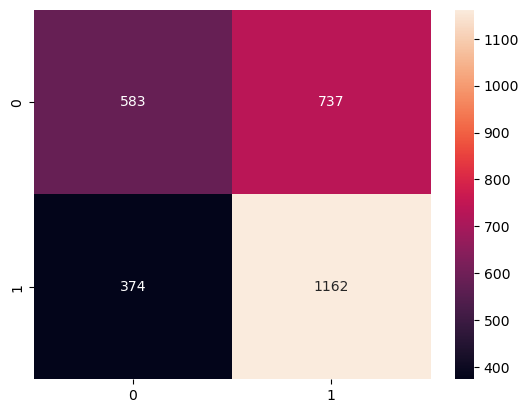

['sgdc_model1.sav']

In [10]:
# classification - SGDClassifier
# train on train data, validate on validation data

clf = SGDClassifier(random_state=5, max_iter=100, tol=None, fit_intercept=False, penalty='l1')
print('fitting...')
clf.fit(new_data_train, y_train)
print('predicting...')
y_pred = clf.predict(new_data_val)

print("Accuracy", accuracy_score(y_val, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_val, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_val,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_hog_heatmap_sgdclassfier_val.pdf')
plt.show()

joblib.dump(clf, 'sgdc_model1.sav')

fitting...
Accuracy 0.67806484295846
P,R,F1: (0.6866331440526403, 0.6783859940872137, 0.6745722586376937, None)


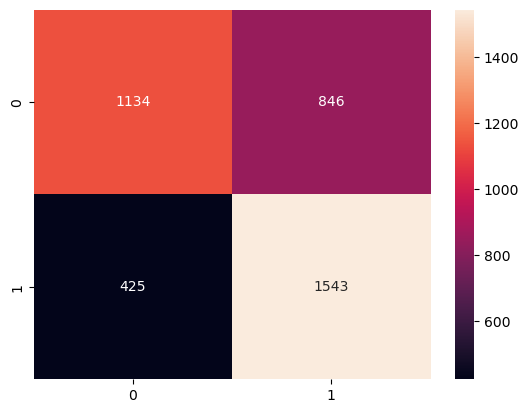

In [17]:
# train on train+val, test on test data
clf = SGDClassifier(random_state=5, max_iter=100, tol=None, fit_intercept=False, penalty='l1')
print('fitting...')
clf.fit(np.vstack((new_data_train,new_data_val)), np.vstack((y_train,y_val)))
joblib.dump(clf, 'sgdc_model2.sav')
y_pred = clf.predict(new_data_test)

print("Accuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_hog_heatmap_sgdclassfier_test2.pdf')
plt.show()

### RandomForestClassifier

fitting...
predicting...
Accuracy 0.7244397759103641
P,R,F1: (0.7249218326593572, 0.7261837121212121, 0.7241597333482237, None)


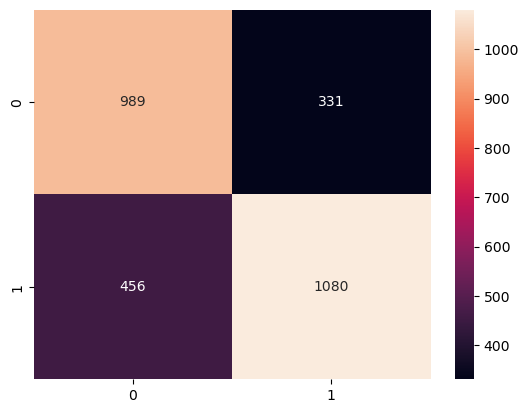

['rf_model1.sav']

In [18]:
# classification - RandomForestClassifier
# train on train data, validate on validation data

clf = RandomForestClassifier(random_state=5, n_estimators=200)
print('fitting...')
clf.fit(new_data_train, y_train)
print('predicting...')
y_pred = clf.predict(new_data_val)

print("Accuracy", accuracy_score(y_val, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_val, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_val,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_hog_heatmap_rf_val.pdf')
plt.show()

joblib.dump(clf, 'rf_model1.sav')  # loaded_model = joblib.load(filename) 

fitting...
Accuracy 0.711499493414387
P,R,F1: (0.7115332041101893, 0.7114760408967726, 0.7114713378726447, None)


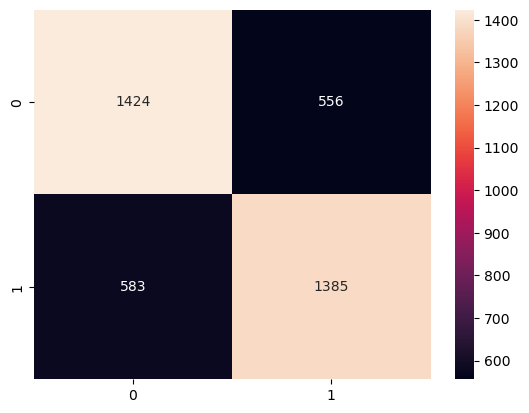

In [20]:
# train on train+val, test on test data
clf = RandomForestClassifier(random_state=5, n_estimators=200)
print('fitting...')
clf.fit(np.vstack((new_data_train,new_data_val)), np.vstack((y_train,y_val)))
joblib.dump(clf, 'rf_model2.sav')
y_pred = clf.predict(new_data_test)

print("Accuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['0','1'], columns = ['0','1'])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('plot_hog_heatmap_rf_test2.pdf')
plt.show()

In [58]:
# misclassified examples

misclass= []
for row_index, (inpt, pred, label) in enumerate(zip(new_data_test, y_pred, y_test.to_numpy().reshape(-1))):
    #print(row_index, pred, label)
    if pred != label:
        misclass.append((row_index, pred, label))

with open('./hog_new_data_test_i.pkl', 'rb') as file:
    new_data_test_i = pickle.load(file)
data_test = pd.read_csv(DATA_TEST_CSV)
X_test = data_test[['img1','img2']]
    
for row_index, pred, label in misclass[8:13]:
    index_og = new_data_test_i[row_index]
    print('pred:',pred,'true:',label,end=' ')
    files = X_test.iloc[index_og]
    print(files['img1'],files['img2'])

pred: 0 true: 1 066/09_066.png 066_forg/04_0127066.PNG
pred: 0 true: 1 058/05_058.png 058_forg/02_0125058.PNG
pred: 1 true: 0 055/07_055.png 055/12_055.png
pred: 0 true: 1 068/08_068.png 068_forg/01_0124068.PNG
pred: 0 true: 1 068/01_068.png 068_forg/02_0124068.PNG


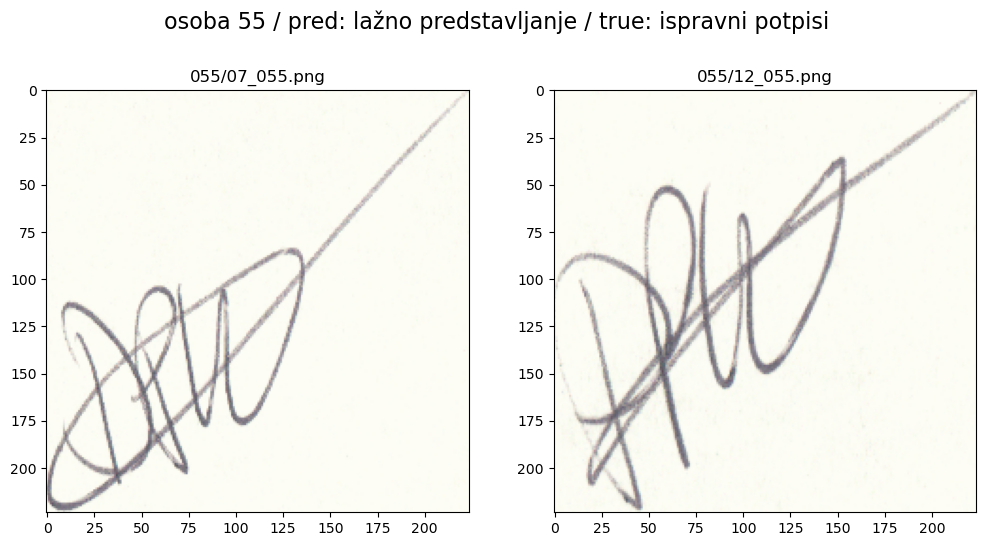

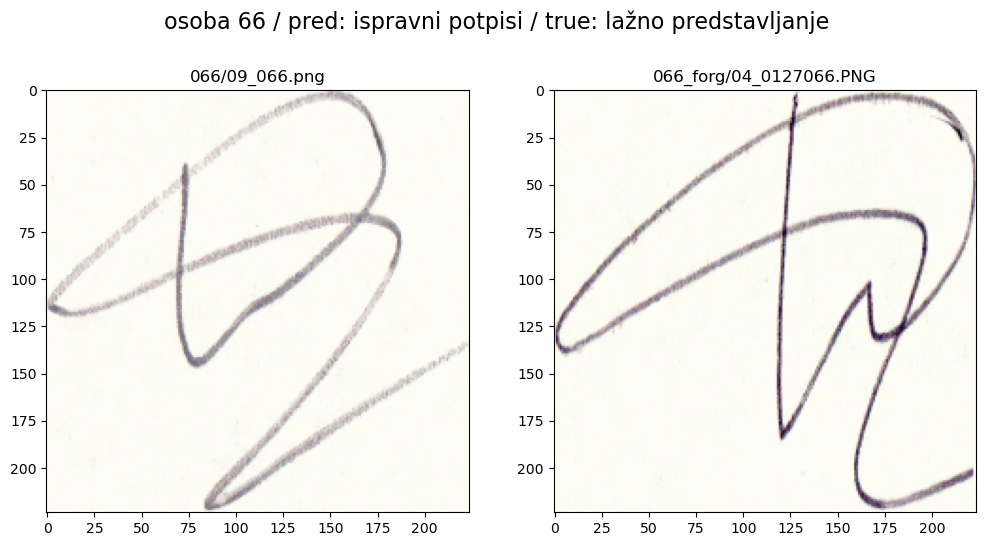

In [60]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('osoba 55 / pred: lažno predstavljanje / true: ispravni potpisi', fontsize=16)
plt.subplot(1,2,1, title='055/07_055.png')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/055/07_055.png'), (SIZE,SIZE)), cmap='gray')
plt.subplot(1,2,2, title='055/12_055.png')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/055/12_055.png'), (SIZE,SIZE)), cmap='gray')
plt.savefig('plot_hog_rf_misclassification1.pdf')
plt.show()

fig = plt.figure(figsize=(12,6))
fig.suptitle('osoba 66 / pred: ispravni potpisi / true: lažno predstavljanje', fontsize=16)
plt.subplot(1,2,1, title='066/09_066.png')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/066/09_066.png'), (SIZE,SIZE)), cmap='gray')
plt.subplot(1,2,2,title='066_forg/04_0127066.PNG')
plt.imshow(cv2.resize(cv2.imread('./sign_data/Dataset/test/066_forg/04_0127066.PNG'), (SIZE,SIZE)), cmap='gray')
plt.savefig('plot_hog_rf_misclassification2.pdf')
plt.show()

In [71]:
print(new_data_train.shape, new_data_val.shape, new_data_test.shape)

(16402, 30976) (2856, 30976) (3948, 30976)
